In [30]:
%matplotlib inline
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from timeit import default_timer as timer
from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, ArrayType
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start
        
def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']
punct_regex_expression = "[!\"#$%&()*+-.\/\\:;<=>?@[\]^_`{|}\\t\\n\',~—]"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Setting up the spark cluster

In [4]:
conf = (SparkConf().setMaster("local[*]")
                .setAppName("SparkVectorizer")
                .set('spark.driver.memory', '300G')
                .set('spark.driver.maxResultSize', '20G')
                .set('spark.network.timeout', '7200s')
                .set('spark.local.dir', './u01/tmp'))
#                .set('spark.executor.cores', '20'))

sc = SparkContext(conf=conf)
# sc.setLogLevel("ERROR")
spark = SparkSession(sc)
print(sc._conf.getAll()) # check context settings

[('spark.driver.maxResultSize', '20G'), ('spark.driver.host', 'd05ea504c36e'), ('spark.app.id', 'local-1627568375489'), ('spark.executor.id', 'driver'), ('spark.local.dir', './u01/tmp'), ('spark.rdd.compress', 'True'), ('spark.network.timeout', '7200s'), ('spark.driver.port', '38403'), ('spark.app.name', 'SparkVectorizer'), ('spark.serializer.objectStreamReset', '100'), ('spark.driver.memory', '300G'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.app.startTime', '1627568374627'), ('spark.ui.showConsoleProgress', 'true')]


In [27]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, data_frac=0.2, result_path="./results.pkl", 
                        seed=42, model_args={}, model_kwargs={}):
    """
    Main function to perform the performance sweep
    """
    data_frac = min(1.0, data_frac)
    overall_perf_result = {"data_fraction": data_frac}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        
        for i in tqdm(range(samples)): 
            sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
            with SimpleTimer() as overalltimer:
                with SimpleTimer() as timer:
                    data = spark.read.parquet(parquet_path).sample(withReplacement=False, fraction=data_frac, seed=seed)
                sample_record["data_read"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    data = data.na.drop(subset=["review_body"])
                    data = data.withColumn("review_body",f.lower(f.col("review_body")))
                    data = data.withColumn("review_body",f.regexp_replace(f.col("review_body"), """[!"#$%&()*+-.\/\\:;<=>?@\[\]^_`{|}\t\n\',~—]""", ' '))
                    data = data.withColumn("review_body",f.trim(f.col("review_body")))
                    tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
                    wordsData = tokenizer.transform(data)                  
                    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=STOPWORDS)
                    cleaned = stopwordsRemover.transform(wordsData)
                    cleaned.head(0)
                sample_record["data_preprocessing"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2**20)
                    featurizedData = hashingTF.transform(cleaned)
                    featurizedData.head(0)
                sample_record["hashing_vectorizer"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {timer.elapsed}s")
                
                with SimpleTimer() as timer:
                    idf = IDF(inputCol="rawFeatures", outputCol="features2").fit(featurizedData)
                    rescaledData = idf.transform(featurizedData)
                    rescaledData.persist(StorageLevel.MEMORY_ONLY)#head(0) # does not do anything but just triggers compute
                sample_record["tfidf_transformer"]=timer.elapsed
                print(f"Workers:{n}, Sample Run:{i}, Finished fitting TfIDTransformer in {timer.elapsed}s")
                
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=  data.count()
            print(f"Workers:{n}, Sample Run:{i}, Finished transforming using TFIDFTransformer in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)
    

In [28]:
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [1]
result_path = f".results/result_poc_nlp_spark_{dataset}_persist.pkl"

In [31]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, data_frac=1, result_path=result_path, 
                        seed=42)

  0%|          | 0/5 [00:00<?, ?it/s]

Workers:1, Sample Run:0, Finished loading data in 91746029s
Workers:1, Sample Run:0, Finished preprocessing data in 133759736s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 22947652s
Workers:1, Sample Run:0, Finished fitting TfIDTransformer in 109331936920s


 20%|██        | 1/5 [01:50<07:21, 110.40s/it]

Workers:1, Sample Run:0, Finished transforming using TFIDFTransformer in 109580861284s
Workers:1, Sample Run:1, Finished loading data in 66571561s
Workers:1, Sample Run:1, Finished preprocessing data in 122637565s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 26344359s
Workers:1, Sample Run:1, Finished fitting TfIDTransformer in 108305515634s


 40%|████      | 2/5 [03:39<05:29, 109.75s/it]

Workers:1, Sample Run:1, Finished transforming using TFIDFTransformer in 108521416870s
Workers:1, Sample Run:2, Finished loading data in 68863748s
Workers:1, Sample Run:2, Finished preprocessing data in 125425317s
Workers:1, Sample Run:2, Finished fitting HashVectorizer in 25947686s
Workers:1, Sample Run:2, Finished fitting TfIDTransformer in 107676548053s


 60%|██████    | 3/5 [05:28<03:38, 109.27s/it]

Workers:1, Sample Run:2, Finished transforming using TFIDFTransformer in 107897058451s
Workers:1, Sample Run:3, Finished loading data in 61580892s
Workers:1, Sample Run:3, Finished preprocessing data in 117546773s
Workers:1, Sample Run:3, Finished fitting HashVectorizer in 23039523s
Workers:1, Sample Run:3, Finished fitting TfIDTransformer in 109175030835s


 80%|████████  | 4/5 [07:18<01:49, 109.60s/it]

Workers:1, Sample Run:3, Finished transforming using TFIDFTransformer in 109377515359s
Workers:1, Sample Run:4, Finished loading data in 58216717s
Workers:1, Sample Run:4, Finished preprocessing data in 111173657s
Workers:1, Sample Run:4, Finished fitting HashVectorizer in 22208775s
Workers:1, Sample Run:4, Finished fitting TfIDTransformer in 108583056808s


100%|██████████| 5/5 [09:08<00:00, 109.61s/it]

Workers:1, Sample Run:4, Finished transforming using TFIDFTransformer in 108774928410s
CPU times: user 285 ms, sys: 118 ms, total: 402 ms
Wall time: 9min 8s


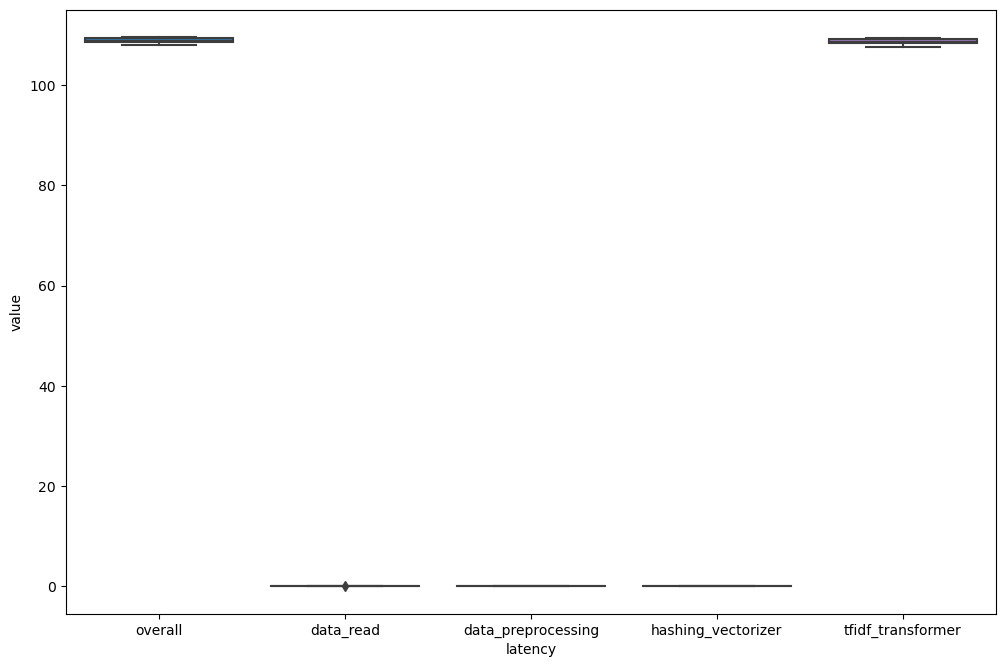

In [32]:
data, melt_data = visualize_data(result_path)    

In [33]:
data

,n_workers,sample_run,overall,data_read,data_preprocessing,hashing_vectorizer,tfidf_transformer,nrows
0,1,0,109.580861,0.091746,0.133760,0.022948,109.331937,7004147
1,1,1,108.521417,0.066572,0.122638,0.026344,108.305516,7004147
2,1,2,107.897058,0.068864,0.125425,0.025948,107.676548,7004147
3,1,3,109.377515,0.061581,0.117547,0.023040,109.175031,7004147
4,1,4,108.774928,0.058217,0.111174,0.022209,108.583057,7004147


In [34]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [35]:
groupy

sample_run                     overall                 data_read  \
                mean       std count        mean       std count      mean   
n_workers                                                                    
1                  2  1.581139     5  108.830356  0.676794     5  0.069396   

                         data_preprocessing  ...       hashing_vectorizer  \
               std count               mean  ... count               mean   
n_workers                                    ...                            
1          0.01317     5           0.122109  ...     5           0.024098   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
1          0.001903     5        108.614418  0.671775     5  7004147  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]